## Data information

### Source 

Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, Véronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.

### Attribute Information

The dataset has attributes and units are as follows:
- date time year-month-day hour:minute:second
- Temperature, in Celsius
- Relative Humidity, %
- Light, in Lux
- CO2, in ppm
- Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
- Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

## Notebook Setup

In [3]:
#Common imports
import sys
import os
import numpy as np

#Python Data Analysis Library
import pandas as pd

#Data visualization
%matplotlib inline 
#sets the backend of matplotlib to the 'inline' backend
#%matplotlib notebook
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Where to save the figures
project_root_dir = "."
project_name = "occupancy_detection"
images_path = os.path.join(project_root_dir, "images", project_name)
os.makedirs(images_path, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Data Import

In [4]:
df_1 = pd.read_csv("datasets/occupancy_detection/datatraining.txt")
df_2 = pd.read_csv("datasets/occupancy_detection/datatest.txt")
df_3 = pd.read_csv("datasets/occupancy_detection/datatest2.txt")
df = pd.concat([df_1,df_2,df_3], axis = 0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20560 entries, 1 to 9752
Data columns (total 7 columns):
date             20560 non-null object
Temperature      20560 non-null float64
Humidity         20560 non-null float64
Light            20560 non-null float64
CO2              20560 non-null float64
HumidityRatio    20560 non-null float64
Occupancy        20560 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


## Data Engineering and Visualization

### Ensuring dtype consistency

Occupancy is our label for this classification project. It was imported as an 'int64' dtype and requires a correct type conversion. 
date col will be converted from object to datetime dtype.

In [7]:
df['Occupancy'] = df['Occupancy'].astype("bool")

In [8]:
df.Occupancy.value_counts()

False    15810
True      4750
Name: Occupancy, dtype: int64

In [29]:
df.date = pd.to_datetime(df.date, format="%Y-%m-%d %H:%M:%S")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20560 entries, 1 to 9752
Data columns (total 7 columns):
date             20560 non-null datetime64[ns]
Temperature      20560 non-null float64
Humidity         20560 non-null float64
Light            20560 non-null float64
CO2              20560 non-null float64
HumidityRatio    20560 non-null float64
Occupancy        20560 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(5)
memory usage: 1.1 MB


### Descriptive statistics

In [31]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228
std,1.055315,4.982154,210.430875,311.201281,0.000768
min,19.000000,16.745000,0.000000,412.750000,0.002674
25%,20.200000,24.500000,0.000000,460.000000,0.003719
50%,20.700000,27.290000,0.000000,565.416667,0.004292
75%,21.525000,31.290000,301.000000,804.666667,0.004832
max,24.408333,39.500000,1697.250000,2076.500000,0.006476


### Percentage of missing value

In [10]:
df.isnull().sum()/len(df)*100

date             0.0
Temperature      0.0
Humidity         0.0
Light            0.0
CO2              0.0
HumidityRatio    0.0
Occupancy        0.0
dtype: float64

### Numerical and Categorical attributes

In [11]:
def coltype(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = list(df.select_dtypes(include=numerics).columns)
    non_numeric =['bool','category']
    categorical = list(df.select_dtypes(include=non_numeric).columns)
    return (numeric, categorical)

In [12]:
df_numeric,df_categorical = coltype(df)

In [13]:
df_numeric

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

In [14]:
df_categorical

['Occupancy']

### Histrograms for numeric 

In [19]:
def hist_plots(data, numeric,col_no):
    data_fig = pd.melt(data, value_vars= numeric)
    fig = sns.FacetGrid(data_fig, col = "variable", col_wrap = col_no,sharex= False, sharey = False)
    fig = fig.map(sns.distplot, "value", color = 'c')
    return fig
#col_no : number of columns to display in one row
#numeric : name of numeric cols

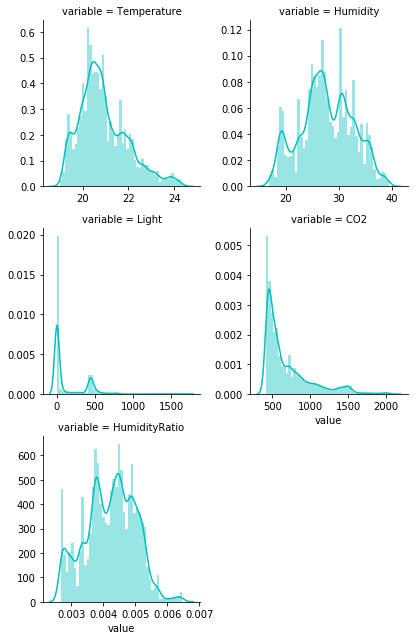

In [23]:
hist_plots(df,df_numeric,2)

## Time Series

In [34]:
df[['date']].values

array([['2015-02-04T17:51:00.000000000'],
       ['2015-02-04T17:51:59.000000000'],
       ['2015-02-04T17:53:00.000000000'],
       ...,
       ['2015-02-18T09:16:59.000000000'],
       ['2015-02-18T09:17:59.000000000'],
       ['2015-02-18T09:19:00.000000000']], dtype='datetime64[ns]')

In [36]:
sns.tsplot(x= df[['date']].values, y = df[['Light']].values)

TypeError: tsplot() missing 1 required positional argument: 'data'